In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import unicodedata
import markdown
import re
import nltk
import os
import prepare as p
import preprocess as pre

from requests import get
from bs4 import BeautifulSoup

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


In [2]:
# Here I read in a csv file with all the data we acquired using api
df = pd.read_csv('all_repos.csv')

In [3]:
# These are null values we identified
df.iloc[686]

repo               mattwaite/NICAR19SportsDataViz
language                                      NaN
readme_contents                               NaN
Name: 686, dtype: object

In [4]:
# All null values in our data
df.isnull().sum()

repo                0
language           72
readme_contents     1
dtype: int64

In [5]:
# I decided to drop all since it makes up a small portion of our data
df.dropna(inplace = True)

In [6]:
df = df[df.readme_contents != 'failedreadme']

In [7]:
# This is what is left after dropping all nulls
df.shape

(883, 3)

In [8]:
# Quick look at our data
df.head()

,repo,language,readme_contents
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN..."
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...


In [9]:
# Count of all the languages that appear
df.language.value_counts()

Python               232
JavaScript           141
Jupyter Notebook      86
R                     43
TypeScript            40
HTML                  40
Java                  39
PHP                   35
Ruby                  30
C#                    24
C++                   22
Dart                  22
Kotlin                20
CSS                   19
Vue                   10
Objective-C           10
Swift                 10
Go                     9
Rust                   6
XSLT                   4
TeX                    3
Shell                  3
Solidity               3
C                      3
Elixir                 3
CoffeeScript           2
MATLAB                 2
Visual Basic .NET      2
Svelte                 2
EJS                    2
Matlab                 2
Scala                  2
Haskell                1
Stata                  1
Visual Basic           1
Haxe                   1
Dockerfile             1
XML                    1
Max                    1
Batchfile              1


# Many of these are not commonly used and some are not actual program languages. I need to either remove or categorize some of these into 'other'

In [10]:
# I created a list of all actual languages and filtered my data to only include the languages in my list. 
# This should reduce the number of observations and change the shape of my dataframe

valid_languages = ["Python", 'HTML', "JavaScript", "R", "Java", "TypeScript", "PHP", "Ruby", "C#", "C++", "Dart", "Kotlin", "Objective-C", "Swift", "Go", "Rust", "C", "Elixir", "CoffeeScript", "MATLAB", "Visual Basic .NET", "Scala", "Haskell", "Stata", "Haxe", "Lua", "Perl", "Clojure"]

# Use the isin method to filter the DataFrame
df = df[df['language'].isin(valid_languages)]

df.head()


,repo,language,readme_contents
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN..."
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...


In [11]:
# Another look at the count of each language that appear.
df.language.value_counts()

Python               232
JavaScript           141
R                     43
TypeScript            40
HTML                  40
Java                  39
PHP                   35
Ruby                  30
C#                    24
Dart                  22
C++                   22
Kotlin                20
Swift                 10
Objective-C           10
Go                     9
Rust                   6
C                      3
Elixir                 3
Visual Basic .NET      2
MATLAB                 2
CoffeeScript           2
Scala                  2
Perl                   1
Lua                    1
Haskell                1
Haxe                   1
Stata                  1
Clojure                1
Name: language, dtype: int64

# I was able to remove all that were not actual languages. Now I need to categorize the remaining into five categories

In [12]:
# Quick look at the total of languages that appear less than 40 times
df.language.value_counts()[df.language.value_counts() < 40].sum()

247

# Since I am keeping the top four languages as is and placing the rest into 'other' category, I should end up with a count total of 287 for 'other' because both html and typescript have the same total count

In [13]:
# List of languages to rename to 'other'
languages_to_rename = ['HTML', 'Java', 'PHP', 'Ruby', 'C#', 'C++', 'Dart', 'Kotlin', 'Objective-C', 'Swift', 'Go', 'Rust', 'C', 'Elixir', 'Visual Basic .NET', 'MATLAB', 'CoffeeScript', 'Scala', 'Perl', 'Lua', 'Haskell', 'Haxe', 'Stata', 'Clojure']

# Replace the specified languages with 'other'
df['language'] = df['language'].replace(languages_to_rename, 'other')


In [14]:
# Quick look at total count of each language to verify accurate count
df.language.value_counts()

other         287
Python        232
JavaScript    141
R              43
TypeScript     40
Name: language, dtype: int64

In [15]:
# Here I concat two series together which outputs the count for each language appearance and the porportion it make up
labels = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
other,287,0.386272
Python,232,0.312248
JavaScript,141,0.189771
R,43,0.057873
TypeScript,40,0.053836


# R and Typscript make up a vary small proportion. This will make it difficult for my models to predict accuratley. Maybe I should add those two the the 'other' category

In [16]:
# The data I am left with
df.shape

(743, 3)

In [17]:
type(' '.join(df[df.language == 'Python']['readme_contents']))

str

# Clean

In [18]:
# Here I call my advanced clean function on my data filtered by each type of language and its 
# corresponding readme contents then split in to a list of words
python_words = p.advanced_clean(' '.join(df[df.language == 'Python']['readme_contents']), l = True, extra_words = ['python','eww','sport']).split()
javascript_words = p.advanced_clean(' '.join(df[df.language == 'JavaScript']['readme_contents']), l = True).split()
r_words = p.advanced_clean(' '.join(df[df.language == 'R']['readme_contents']), l = True).split()
typescript_words = p.advanced_clean(' '.join(df[df.language == 'TypeScript']['readme_contents']), l = True).split()
other_words = p.advanced_clean(' '.join(df[df.language == 'other']['readme_contents']), l = True).split()
all_words = p.advanced_clean(' '.join(df.readme_contents), l = True).split()

Removed 35126 stopwords
---
Removed 21314 stopwords
---
Removed 5593 stopwords
---
Removed 6177 stopwords
---
Removed 21017 stopwords
---
Removed 71780 stopwords
---


In [19]:
len(python_words), len(javascript_words), len(r_words), len(typescript_words), len(other_words), len(all_words)

(68759, 45389, 11774, 11051, 51853, 155443)

In [20]:
# The results is a list of words
type(python_words)


list

In [21]:
# Here I create a series out of my list of words and get the total count for each unique word
python_freq = pd.Series(python_words).value_counts()
javascript_freq = pd.Series(javascript_words).value_counts()
r_freq = pd.Series(r_words).value_counts()
typescript_freq = pd.Series(typescript_words).value_counts()
other_freq = pd.Series(other_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [22]:
# Frequency for all unique words in readme's using python
python_freq

barry             746
data              541
file              510
team              361
bee               361
                 ... 
1200                1
raining             1
resumebrochure      1
wistful             1
cvnlpendterm        1
Length: 13907, dtype: int64

In [23]:
# Frequency for all unique words in readme's using javascript
javascript_freq

team           324
data           292
get            263
game           256
sport          256
              ... 
musicvocal       1
musicreggae      1
musicrb          1
musicopera       1
printed          1
Length: 9314, dtype: int64

In [24]:
# Frequency for all unique words in readme's using R
r_freq

r                 210
team              190
data              164
season             97
package            95
                 ... 
scalecolorfill      1
expectation         1
relates             1
librarylahman       1
sourcemainr         1
Length: 3783, dtype: int64

In [25]:
# Frequency for all unique words in readme's using typescript
typescript_freq

run            121
data           121
app             79
import          77
use             71
              ... 
partida          1
cadastrados      1
previamente      1
futebol          1
moscow           1
Length: 3207, dtype: int64

In [26]:
# Frequency for all unique words in readme's using other
other_freq

get                  1208
team                  561
player                401
data                  391
database              356
                     ... 
resignin                1
showcase                1
asianoddsplacebet       1
192                     1
optionally              1
Length: 10671, dtype: int64

In [27]:
# Frequency for all unique words
all_freq

data          1181
team           987
file           904
sport          886
game           797
              ... 
messenger        1
bungee           1
cord             1
slingshot        1
replicated       1
Length: 26456, dtype: int64

In [48]:
type(python_freq)

pandas.core.series.Series

In [28]:
# Quick look at the total amount of unique words in each list
len(python_freq), len(javascript_freq), len(r_freq), len(typescript_freq), len(other_freq), len(all_freq)

(13907, 9314, 3783, 3207, 10671, 26456)

In [29]:
len(python_freq[python_freq < 50])

13693

# Majority of the words occur less than 50 times. I think I will remove this words since they dont have any significance

In [30]:
# Here I filter out all the words fir each list that occur more than 50 times
python_freq = python_freq[python_freq > 50]
javascript_freq = javascript_freq[javascript_freq > 50]
r_freq = r_freq[r_freq > 10]
typescript_freq = typescript_freq[typescript_freq > 10]
other_freq = other_freq[other_freq > 50]
all_freq = all_freq[all_freq > 50]

len(python_freq), len(javascript_freq), len(r_freq), len(typescript_freq), len(other_freq), len(all_freq)

(205, 122, 170, 204, 156, 524)

# Removing those words siginificantly reduced the total amount of words in each list. But this is the frequency. I need to apply to same method to the actual words.

In [31]:
type(python_words)

list

In [32]:
# Here I create a list of extra words I want to remove from each list of words

extra_words1 = (pd.Series(python_words).value_counts()[pd.Series(python_words).value_counts() < 51]).index.values
extra_words2 = (pd.Series(javascript_words).value_counts()[pd.Series(javascript_words).value_counts() < 51]).index
extra_words3 = (pd.Series(r_words).value_counts()[pd.Series(r_words).value_counts() < 51]).index
extra_words4 = (pd.Series(typescript_words).value_counts()[pd.Series(typescript_words).value_counts() < 51]).index
extra_words5 = (pd.Series(other_words).value_counts()[pd.Series(other_words).value_counts() < 51]).index

In [33]:
len(extra_words1)

13702

In [34]:
# Here I rejoin my words so that I can add extra words to my stopword list
python_words = ' '.join(python_words)
javascript_words = ' '.join(javascript_words)
r_words = ' '.join(r_words)
typescript_words = ' '.join(typescript_words)
other_words = ' '.join(other_words)

In [35]:
# Here I remove the words from the list i created above
python_words = p.remove_stopwords(python_words, extra_words = extra_words1).split()
javascript_words = p.remove_stopwords(javascript_words, extra_words = extra_words2).split()
r_words = p.remove_stopwords(r_words, extra_words = extra_words3).split()
typescript_words = p.remove_stopwords(typescript_words, extra_words = extra_words4).split()
other_words = p.remove_stopwords(other_words, extra_words = extra_words5).split()


Removed 46392 stopwords
---
Removed 32868 stopwords
---
Removed 10370 stopwords
---
Removed 9892 stopwords
---
Removed 34560 stopwords
---


In [49]:
type(python_words)

list

In [38]:
# Quick look at the total words i am left with
len(python_words), len(javascript_words), len(r_words), len(typescript_words), len(other_words), len(all_words)

(22367, 12521, 1404, 1159, 17293, 155443)

# Should I remove all duplicates?

In [40]:
len(pd.unique(python_words))

205

# Actually I need all words to get the frequency of each word

In [41]:
# Quick look at all the bigrams in this list of words
list(nltk.bigrams(python_words))

[('machine', 'data'),
 ('data', 'library'),
 ('library', 'well'),
 ('well', 'package'),
 ('package', 'feature'),
 ('feature', 'run'),
 ('run', 'machine'),
 ('machine', 'model'),
 ('model', 'using'),
 ('using', 'generate'),
 ('generate', 'create'),
 ('create', 'model'),
 ('model', 'event'),
 ('event', 'system'),
 ('system', 'using'),
 ('using', 'image'),
 ('image', 'model'),
 ('model', 'documentation'),
 ('documentation', 'installation'),
 ('installation', 'pip'),
 ('pip', 'installed'),
 ('installed', 'system'),
 ('system', 'see'),
 ('see', 'run'),
 ('run', 'following'),
 ('following', 'command'),
 ('command', 'install'),
 ('install', 'pip'),
 ('pip', 'install'),
 ('install', 'u'),
 ('u', 'installed'),
 ('installed', 'following'),
 ('following', 'create'),
 ('create', 'object'),
 ('object', 'install'),
 ('install', 'command'),
 ('command', 'pip'),
 ('pip', 'install'),
 ('install', 'git'),
 ('git', 'window'),
 ('window', 'user'),
 ('user', 'install'),
 ('install', 'pip'),
 ('pip', 'insta

In [42]:
# Quick look at all the bigrams in this list of words
list(nltk.bigrams(javascript_words))

[('nba', 'api'),
 ('api', 'npm'),
 ('npm', 'install'),
 ('install', 'nba'),
 ('nba', 'nba'),
 ('nba', 'application'),
 ('application', 'using'),
 ('using', 'work'),
 ('work', 'work'),
 ('work', 'server'),
 ('server', 'information'),
 ('information', 'application'),
 ('application', 'used'),
 ('used', 'run'),
 ('run', 'server'),
 ('server', 'change'),
 ('change', 'point'),
 ('point', 'nba'),
 ('nba', 'api'),
 ('api', 'number'),
 ('number', 'json'),
 ('json', 'library'),
 ('library', 'api'),
 ('api', 'return'),
 ('return', 'object'),
 ('object', 'player'),
 ('player', 'name'),
 ('name', 'id'),
 ('id', 'team'),
 ('team', 'information'),
 ('information', 'method'),
 ('method', 'method'),
 ('method', 'object'),
 ('object', 'object'),
 ('object', 'stats'),
 ('stats', 'j'),
 ('j', 'const'),
 ('const', 'nba'),
 ('nba', 'const'),
 ('const', 'example'),
 ('example', 'api'),
 ('api', 'call'),
 ('call', 'see'),
 ('see', 'test'),
 ('test', 'file'),
 ('file', 'api'),
 ('api', 'change'),
 ('change', 

In [43]:
# Quick look at all the bigrams in this list of words
list(nltk.bigrams(r_words))

[('league', 'function'),
 ('function', 'season'),
 ('season', 'data'),
 ('data', 'data'),
 ('data', 'data'),
 ('data', 'r'),
 ('r', 'package'),
 ('package', 'function'),
 ('function', 'data'),
 ('data', 'league'),
 ('league', 'data'),
 ('data', 'data'),
 ('data', 'data'),
 ('data', 'league'),
 ('league', 'data'),
 ('data', 'r'),
 ('r', 'package'),
 ('package', 'r'),
 ('r', 'data'),
 ('data', 'r'),
 ('r', 'result'),
 ('result', 'game'),
 ('game', 'result'),
 ('result', 'season'),
 ('season', 'result'),
 ('result', 'league'),
 ('league', 'result'),
 ('result', 'league'),
 ('league', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'league'),
 ('league', 'result'),
 ('result', 'league'),
 ('league', 'result'),
 ('result', 'name'),
 ('name', 'team'),
 ('team', 'league'),
 ('league', 'data'),
 ('data', 'team'),
 ('team', 'result'),
 ('result', 'league'),
 ('league', 'league'),
 ('league', 'data'),
 ('data', 'league'),
 ('league', 'data'),
 ('data', 'data'),
 ('data', 'da

In [44]:
# Quick look at all the bigrams in this list of words
list(nltk.bigrams(typescript_words))

[('sport', 'player'),
 ('player', 'project'),
 ('project', 'run'),
 ('run', 'get'),
 ('get', 'project'),
 ('project', 'project'),
 ('project', 'using'),
 ('using', 'app'),
 ('app', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'file'),
 ('file', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'sport'),
 ('sport', 'sport'),
 ('sport', 'run'),
 ('run', 'run'),
 ('run', 'use'),
 ('use', 'get'),
 ('get', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'use'),
 ('use', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'file'),
 ('file', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'app'),
 ('app', 'run'),
 ('run', 'data'),
 ('data', 'run'),
 ('run', 'run'),
 ('run', 'data'),
 ('data', 'data'),
 ('data', 'data'),
 ('data', 'player'),
 ('player', 'run'),
 ('run', 'use'),
 ('use', 'use'),
 ('use', 'run'),
 ('run', 'new'),
 ('new', 'use'),
 ('use', 'get'),
 ('get', 'project'),
 ('project', 'create'),
 ('create

In [45]:
# Quick look at all the bigrams in this list of words
list(nltk.bigrams(other_words))

[('view', 'json'),
 ('json', 'application'),
 ('application', 'project'),
 ('project', 'page'),
 ('page', 'available'),
 ('available', 'download'),
 ('download', 'github'),
 ('github', 'issue'),
 ('issue', 'page'),
 ('page', 'table'),
 ('table', 'sport'),
 ('sport', 'like'),
 ('like', 'like'),
 ('like', 'change'),
 ('change', 'want'),
 ('want', 'download'),
 ('download', 'used'),
 ('used', 'data'),
 ('data', 'like'),
 ('like', 'app'),
 ('app', 'also'),
 ('also', 'want'),
 ('want', 'also'),
 ('also', 'repository'),
 ('repository', 'like'),
 ('like', 'version'),
 ('version', 'see'),
 ('see', 'use'),
 ('use', 'version'),
 ('version', 'tournament'),
 ('tournament', 'tournament'),
 ('tournament', 'data'),
 ('data', 'feature'),
 ('feature', 'list'),
 ('list', 'number'),
 ('number', 'use'),
 ('use', 'team'),
 ('team', 'version'),
 ('version', 'install'),
 ('install', 'version'),
 ('version', 'version'),
 ('version', 'tournament'),
 ('tournament', 'version'),
 ('version', 'first'),
 ('first', 

In [54]:
# Here I concatanate each series side by side and sort the words in alphabetical order to create a dataframe with 
# new column names in integer types
word_counts = (pd.concat([all_freq, other_freq, python_freq, javascript_freq, r_freq, typescript_freq], axis=1, sort=True)
                .set_axis(['all', 'other', 'python', 'javascript', 'r', 'typescript'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.tail()

,all,other,python,javascript,r,typescript
yahoo,118,0,53,0,0,0
yarn,0,0,0,0,0,36
year,170,0,0,117,12,0
youre,111,0,79,62,0,0
zip,53,0,0,0,0,0


In [61]:
# Here I sort my dataframe by the python column in descending order
word_counts.sort_values(by='all', ascending=False).head(10)

,all,other,python,javascript,r,typescript
data,1181,391,541,292,164,121
team,987,561,361,324,190,14
file,904,234,510,171,33,70
sport,886,296,307,256,57,54
game,797,296,357,256,83,46
barry,746,0,746,0,0,0
get,660,1208,179,263,32,53
use,645,223,281,140,47,71
example,564,108,223,229,41,17
run,553,133,307,151,13,121


In [51]:
# Here I concatenate datframes on top of eachother where each dataframe represents each language filtered
# by word counts equal to 0 then sorted by the next langauge
pd.concat([word_counts[word_counts.python == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.javascript == 0].sort_values(by='python').tail(6),
           word_counts[word_counts.r == 0].sort_values(by='typescript').tail(6),
           word_counts[word_counts.typescript == 0].sort_values(by='r').tail(6),
           word_counts[word_counts.other == 0].sort_values(by='all').tail(6)])

,all,other,python,javascript,r,typescript
year,170,0,0,117,12,0
kind,154,0,0,126,0,0
group,172,0,0,144,0,0
npm,125,0,0,160,0,58
const,184,0,0,162,0,32
state,231,0,0,172,0,0
pip,144,0,152,0,0,0
de,220,0,155,0,0,32
adam,180,0,180,0,0,0
model,385,86,224,0,68,0


(-0.5, 399.5, 199.5, -0.5)

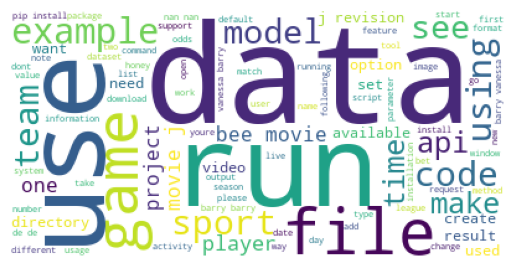

In [53]:
python_img = WordCloud(background_color='white').generate(' '.join (python_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(python_img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

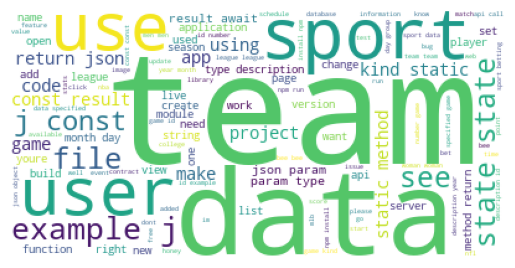

In [55]:
javascript_img = WordCloud(background_color='white').generate(' '.join (javascript_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(javascript_img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

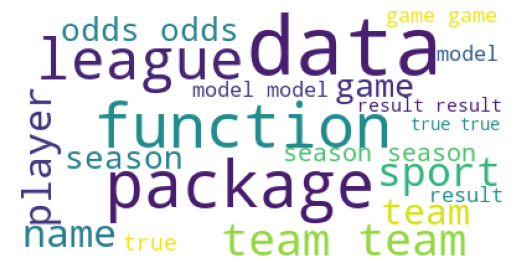

In [56]:
r_img = WordCloud(background_color='white').generate(' '.join (r_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(r_img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

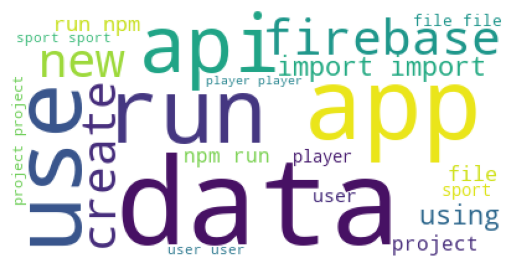

In [57]:
typescript_img = WordCloud(background_color='white').generate(' '.join (typescript_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(typescript_img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

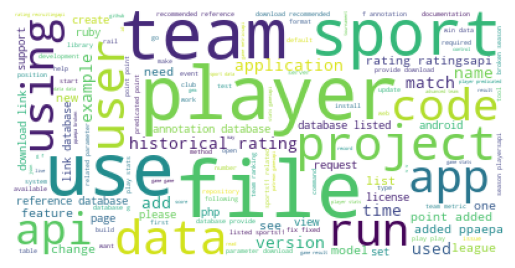

In [58]:
other_img = WordCloud(background_color='white').generate(' '.join (other_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(other_img)
# axis aren't very useful for a word cloud
plt.axis('off')

Text(0.5, 1.0, 'Proportion of the 20 most common words')

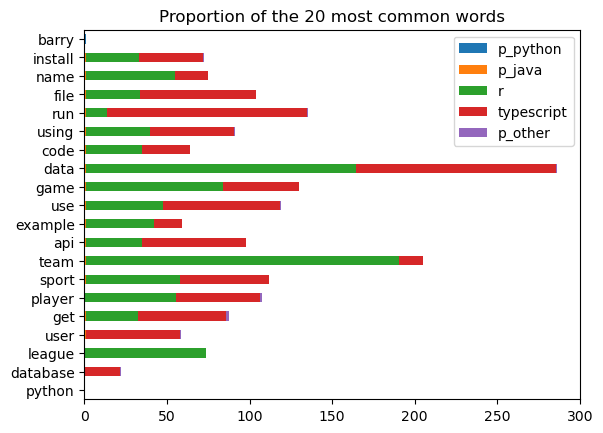

In [60]:

(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.javascript / word_counts['all'],
         p_r=word_counts.r / word_counts['all'],
         p_typescript=word_counts.typescript / word_counts['all'],
         p_other=word_counts.other / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_java', 'r', 'typescript', 'p_other']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of the 20 most common words')

In [ ]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

In [ ]:
top_20_python_bigrams.sort_values(ascending=False).plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [ ]:
len(all_words)

In [ ]:
len(np.unique(all_words))

In [ ]:
df.readme_contents.str.split()

In [ ]:
dictionary = {'barry': 1, 'install': 1}

In [ ]:
dictionary.keys()

In [ ]:
if 'random' in dictionary.keys():
    
    dictionary['random'] += 1
    
dictionary

In [ ]:
dictionary['no'] = 1


In [ ]:
dictionary

# Modeling

In [ ]:
df['clean_text'] = df.readme_contents.apply(p.advanced_clean)

In [ ]:
df['lemmas'] = df.readme_contents.apply(p.advanced_clean, l = True)

In [ ]:
df.head()

In [ ]:
train, val, test = pre.train_val_test(df, strat = 'language', stratify = True)

In [ ]:
train.head()

In [ ]:
X_train, y_train = pre.xy_split(train)
X_val, y_val = pre.xy_split(val)
X_test, y_test = pre.xy_split(test)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

In [ ]:
X_train.head()

In [ ]:
y_train.value_counts()

In [ ]:
 y_train.shape[0] * 100

In [ ]:
baseline_acc = y_train.value_counts().max() / y_train.shape[0] * 100

print(f'Baseline accuracy: {round(baseline_acc, 2)}.')

In [ ]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train.lemmas)
X_val_tfidf = tfidf.transform(X_val.lemmas)
X_test_tfidf = tfidf.transform(X_test.lemmas)

X_train_tfidf[:10]

In [ ]:
pd.DataFrame(X_train_tfidf.todense(), columns=tfidf.get_feature_names_out())


# Logistic Regression

In [ ]:
lm = LogisticRegression(class_weight = 'balanced')

lm.fit(X_train_tfidf, y_train)

In [ ]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': lm.predict(X_train_tfidf)})

y_train_res.head()

In [ ]:
print(classification_report(y_train_res.actual, y_train_res.preds))

In [ ]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': lm.predict(X_val_tfidf)})

y_val_res.head()

In [ ]:
print(classification_report(y_val_res.actual, y_val_res.preds))

# Random Forest

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced')
rf.fit(X_train_tfidf, y_train)

In [ ]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': rf.predict(X_train_tfidf)})

y_train_res.head()

In [ ]:
print(classification_report(y_train_res.actual, y_train_res.preds))

In [ ]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': rf.predict(X_val_tfidf)})

y_val_res.head()

In [ ]:
print(classification_report(y_val_res.actual, y_val_res.preds))

# Decision Tree

In [ ]:
dt = DecisionTreeClassifier(class_weight = 'balanced')
    
dt.fit(X_train_tfidf, y_train)

In [ ]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': dt.predict(X_train_tfidf)})

y_train_res.head()

In [ ]:
print(classification_report(y_train_res.actual, y_train_res.preds))

In [ ]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': dt.predict(X_val_tfidf)})

y_val_res.head()

In [ ]:
print(classification_report(y_val_res.actual, y_val_res.preds))

# KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
    
knn.fit(X_train_tfidf, y_train)

In [ ]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': knn.predict(X_train_tfidf)})

y_train_res.head()

In [ ]:
print(classification_report(y_train_res.actual, y_train_res.preds))

In [ ]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': knn.predict(X_val_tfidf)})

y_val_res.head()

In [ ]:
print(classification_report(y_val_res.actual, y_val_res.preds))